In [712]:
# import lib
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import MinMaxScaler

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN, GRU
from keras.layers import Dropout

from keras.optimizers import Adam
from keras.models import save_model
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

from keras.regularizers import l2
import joblib

import pandas as pd
import numpy as np
import pickle

In [713]:
df = pd.read_csv("data.csv")
df.set_index("date")

,price,warehouse_capacity,truck_capacity
date,,,
2021-01-01,51.58,497,502
2021-01-02,64.55,499,503
2021-01-03,89.02,506,504
2021-01-04,139.49,502,504
2021-01-05,130.83,511,508
...,...,...,...
2024-12-27,62.64,649,618
2024-12-28,117.92,628,603
2024-12-29,110.07,660,622


In [714]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1461 entries, 0 to 1460
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   date                1461 non-null   object 
 1   price               1461 non-null   float64
 2   warehouse_capacity  1461 non-null   int64  
 3   truck_capacity      1461 non-null   int64  
dtypes: float64(1), int64(2), object(1)
memory usage: 45.8+ KB


In [715]:
sc = MinMaxScaler(feature_range=(0, 1))

In [716]:
df_scaled = sc.fit_transform(df[['price', 'warehouse_capacity', 'truck_capacity']])

In [717]:
df.info

<bound method DataFrame.info of             date   price  warehouse_capacity  truck_capacity
0     2021-01-01   51.58                 497             502
1     2021-01-02   64.55                 499             503
2     2021-01-03   89.02                 506             504
3     2021-01-04  139.49                 502             504
4     2021-01-05  130.83                 511             508
...          ...     ...                 ...             ...
1456  2024-12-27   62.64                 649             618
1457  2024-12-28  117.92                 628             603
1458  2024-12-29  110.07                 660             622
1459  2024-12-30  146.30                 636             608
1460  2024-12-31   86.23                 659             637

[1461 rows x 4 columns]>

In [718]:
windows = 30
X_train = []
y_train = []

In [719]:
for i in range(windows, len(df)):
    X_train.append(df_scaled[i - windows:i])
    y_train.append(df_scaled[i])

In [720]:
X_train = np.array(X_train)
y_train = np.array(y_train)
print(X_train.shape)
print(y_train.shape)

(1431, 30, 3)
(1431, 3)


In [721]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

In [722]:
def LSTM_model():
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=16
    model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(0.2))
    
    # # Adding a second LSTM layer and some Dropout regularisation
    layer_2_units=32
    model.add(LSTM(units = layer_2_units))
    model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))
    
    # Compiling the LSTM
    learning_rate = 0.0001  # You can adjust this value as needed
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer = optimizer, loss = 'mean_absolute_percentage_error')

    return model

In [723]:
def simple_LSTM_model():
    model = Sequential()

    # Adding the first LSTM layer and some Dropout regularisation
    layer_1_units=64
    model.add(LSTM(units = layer_1_units, activation='relu', input_shape = (X_train.shape[1], X_train.shape[2])))
    
    # Adding the output layer
    model.add(Dense(units = y_train.shape[1]))
    
    # Compiling the RNN
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')

    return model

In [724]:
model_LSTM = LSTM_model()

early_stopping = EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)

In [725]:
# Fitting the RNN to the Training set
epoch_no=200
batch_size=32
history = model_LSTM.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/200
41/41 [==============================] - 3s 24ms/step - loss: 22350.1133 - val_loss: 100.9728
Epoch 2/200
41/41 [==============================] - 1s 13ms/step - loss: 16103.5645 - val_loss: 99.1759
Epoch 3/200
41/41 [==============================] - 1s 12ms/step - loss: 11320.4814 - val_loss: 99.6688
Epoch 4/200
41/41 [==============================] - 1s 12ms/step - loss: 21760.1055 - val_loss: 100.4762
Epoch 5/200
41/41 [==============================] - 1s 12ms/step - loss: 24488.0801 - val_loss: 102.5713
Epoch 6/200
41/41 [==============================] - 1s 12ms/step - loss: 22121.5117 - val_loss: 99.7791
Epoch 7/200
41/41 [==============================] - 1s 12ms/step - loss: 9716.9023 - val_loss: 98.4454
Epoch 8/200
41/41 [==============================] - 1s 12ms/step - loss: 14923.3008 - val_loss: 96.2657
Epoch 9/200
41/41 [==============================] - 1s 13ms/step - loss: 26078.8066 - val_loss: 95.9439
Epoch 10/200
41/41 [==============================] -

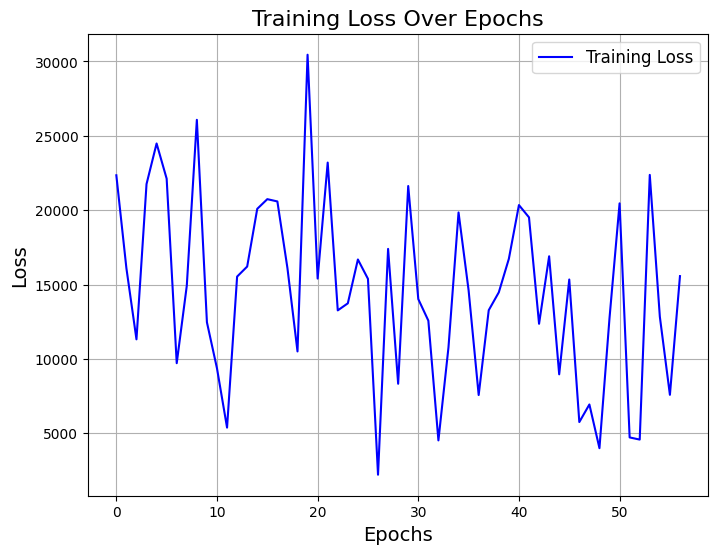

In [726]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [740]:
def RNN_model():
    model = Sequential()
    
    # Adding the first RNN layer and some Dropout regularisation
    layer_1_units = 50
    model.add(SimpleRNN(units=layer_1_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    
    # # Adding a second RNN layer and some Dropout regularisation
    # layer_2_units = 32
    # model.add(SimpleRNN(units=layer_2_units))
    # model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the RNN
    # learning_rate = 0.0001  # You can adjust this value as needed
    # optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    
    return model

In [741]:
def GRU_model():
    model = Sequential()
    
    # Adding the first GRU layer and some Dropout regularisation
    layer_1_units = 50
    model.add(GRU(units=layer_1_units, input_shape=(X_train.shape[1], X_train.shape[2])))
    # model.add(Dropout(0.2))
    
    # # Adding a second GRU layer and some Dropout regularisation
    # model.add(GRU(units=32))
    # model.add(Dropout(0.1))
    
    # Adding the output layer
    model.add(Dense(units=y_train.shape[1]))
    
    # Compiling the GRU
    # learning_rate = 0.0001  # You can adjust this value as needed
    # optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer='adam', loss='mean_absolute_percentage_error')
    
    return model

In [742]:
model_rnn = RNN_model()
history = model_rnn.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/200
41/41 [==============================] - 1s 7ms/step - loss: 94253.6172 - val_loss: 281.7910
Epoch 2/200
41/41 [==============================] - 0s 4ms/step - loss: 676716.4375 - val_loss: 351.7953
Epoch 3/200
41/41 [==============================] - 0s 4ms/step - loss: 350593.3438 - val_loss: 178.2875
Epoch 4/200
41/41 [==============================] - 0s 4ms/step - loss: 237215.1562 - val_loss: 212.1848
Epoch 5/200
41/41 [==============================] - 0s 4ms/step - loss: 303563.2500 - val_loss: 193.2116
Epoch 6/200
41/41 [==============================] - 0s 4ms/step - loss: 141451.2812 - val_loss: 179.7019
Epoch 7/200
41/41 [==============================] - 0s 5ms/step - loss: 250853.8906 - val_loss: 147.6824
Epoch 8/200
41/41 [==============================] - 0s 4ms/step - loss: 165616.8906 - val_loss: 167.8600
Epoch 9/200
41/41 [==============================] - 0s 4ms/step - loss: 229076.0469 - val_loss: 146.0269
Epoch 10/200
41/41 [===========================

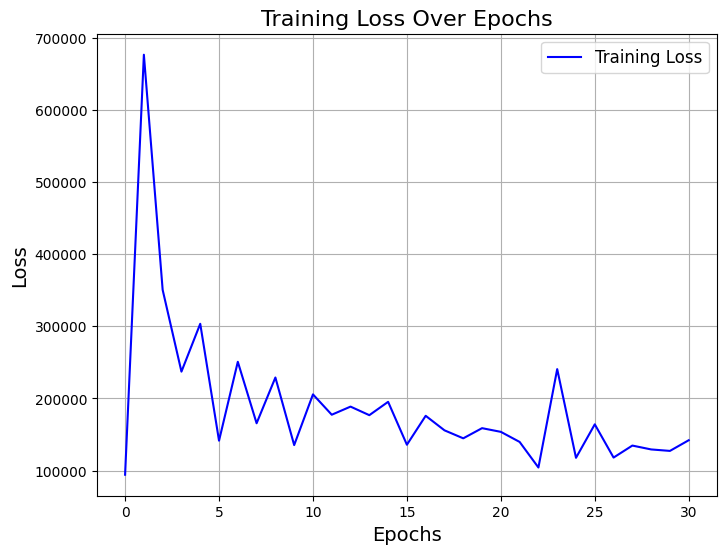

In [743]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [744]:
model_gru = GRU_model()
history = model_gru.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
                         validation_data=(X_val, y_val))

Epoch 1/200
41/41 [==============================] - 2s 14ms/step - loss: 48481.3008 - val_loss: 58.1483
Epoch 2/200
41/41 [==============================] - 0s 8ms/step - loss: 58806.9609 - val_loss: 52.3681
Epoch 3/200
41/41 [==============================] - 0s 7ms/step - loss: 27696.3301 - val_loss: 114.4078
Epoch 4/200
41/41 [==============================] - 0s 7ms/step - loss: 98046.0625 - val_loss: 80.0221
Epoch 5/200
41/41 [==============================] - 0s 8ms/step - loss: 23451.3613 - val_loss: 98.7879
Epoch 6/200
41/41 [==============================] - 0s 7ms/step - loss: 74494.8203 - val_loss: 52.1951
Epoch 7/200
41/41 [==============================] - 0s 7ms/step - loss: 26990.2070 - val_loss: 128.3559
Epoch 8/200
41/41 [==============================] - 0s 8ms/step - loss: 98133.3594 - val_loss: 72.1045
Epoch 9/200
41/41 [==============================] - 0s 7ms/step - loss: 21237.5781 - val_loss: 102.9796
Epoch 10/200
41/41 [==============================] - 0s 8ms

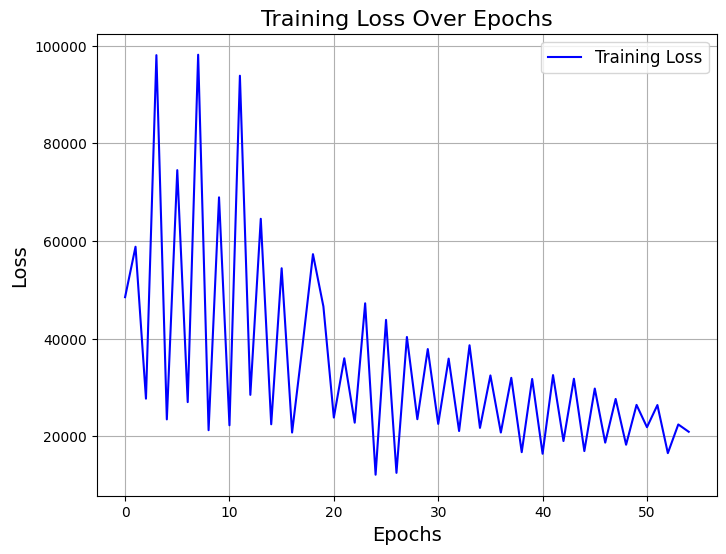

In [745]:
train_loss = history.history['loss']

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss', color='blue')
plt.title('Training Loss Over Epochs', fontsize=16)
plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [746]:
# save_model
model_LSTM.save('./model_lstm.h5')
model_rnn.save('./model_rnn.h5')
model_gru.save('./model_gru.h5')

In [734]:
joblib.dump(sc, 'scaler.pkl')

['scaler.pkl']

In [735]:
type(sc)

sklearn.preprocessing._data.MinMaxScaler

In [736]:
# simple_model_LSTM = simple_LSTM_model()

# early_stopping = EarlyStopping(monitor='loss', patience=10, restore_best_weights=True)

In [737]:
# # Fitting the RNN to the Training set
# epoch_no=64
# batch_size=44
# history = simple_model_LSTM.fit(X_train, y_train, epochs = epoch_no, batch_size = batch_size, callbacks=[early_stopping],
#                          validation_data=(X_val, y_val))

In [738]:
# train_loss = history.history['loss']

# plt.figure(figsize=(8, 6))
# plt.plot(train_loss, label='Training Loss', color='blue')
# plt.title('Training Loss Over Epochs', fontsize=16)
# plt.xlabel('Epochs', fontsize=14)
# plt.ylabel('Loss', fontsize=14)
# plt.legend(fontsize=12)
# plt.grid(True)
# plt.show()

In [739]:
# simple_model_LSTM.save('./simple_model_lstm.h5')